# Titanic: quem morreu e quem sobreviveu?

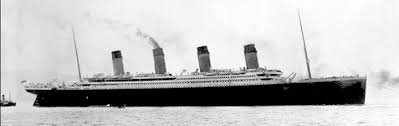

In [94]:
from IPython.display import Image
Image(filename='titanic.jpeg', width=800, height=200)

O Titanic foi um navio construído na Irlanda, que naufragou quatro dias após sua viagem de inauguração em abril de 1912. Essa acidente é muito conhecido, ainda mais depois do lançamento do filme em 1997.
Esse projeto visa criar um modelo a fim de predizer quem morreu e quem sobreviveu nesse desastre, com base no [Dataset do Titanic do Kaggle](https://www.kaggle.com/c/titanic).

Utilizaremos uma versão semi-limpa do dataset e o modelo de Regressão Logística para classificar os que morreram e os que sobreviveram.

## Importando bibliotecas

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Importando os dados

In [96]:
train = pd.read_csv('titanic_dataset.csv')

In [97]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Esse conjunto de dados contém as seguintes informações:
- PassengerId: número de identificação dos passageiros
- Survived: informação se sobreviveu o morreu (0=não e 1=sim)
- Pclass: classe ocupada (1, 2 ou 3)
- Name: nome do passageiro
- Sex: sexo
- Age: Idade
- SibSp: acompanhado de irmãos ou esposo(a)s
- Parch: acompanhado dos pais / crianças a bordo
- Ticket: número da passagem
- Fare: valor pago pela passagem
- Cabin: número da cabine
- Embarked: porto de embarcação (C = Cherbourg, Q = Queenstown, S = Southampton)


## Análise exploratória dos dados

In [98]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


*** Esse dataset de treino conta com 891 entradas, e segundo esse resultado acima já verificamos que há dados faltantes. Vejamos de forma mais clara no heatmap abaixo: ***

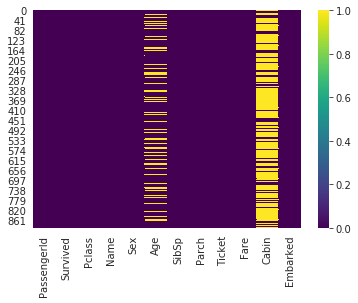

In [100]:
sns.heatmap(train.isnull(), cmap='viridis')

Cerca de 20% dos dados de idade estão faltando. A proporção de idade que falta é provavelmente pequena o suficiente para que possamos fazer uma substituição razoável com alguma forma de imputação de dados. Olhando para a coluna Cabin, porém, parece que estamos perdendo muito desses dados para fazermos o mesmo. Provavelmente vamos descartar essa coluna na construção do modelo.

### Visualizamos no gráfico a quantidade de pessoas que morreram e sobreviveram

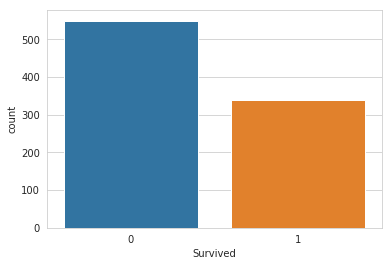

In [91]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train)

**Vimos por esse gráfico que a maioria das pessoas morreram.**

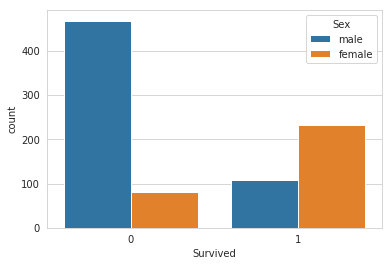

In [64]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue= 'Sex',data=train)

**Dentre as pessoas que morreram, a maioria é homem e entre as que sobreviveram a maioria é mulher. Isso corrobora com o que vimos no filme, onde mulheres e crianças tinha prioridade de embarca no barco salva vidas.**

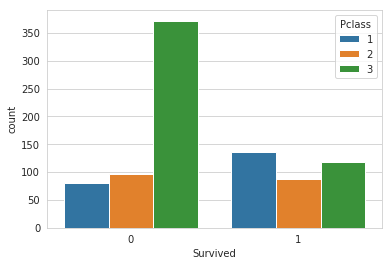

In [65]:
sns.set_style(style='whitegrid')
sns.countplot(x='Survived', hue='Pclass', data=train)

**Por esse outro gráfico, vimos que a maioria das pessoas que morreram pertenciam a terceira classe, mas isso se deve pela maioria das pessoas pertenceram a essa classe, como vemos no gráfico seguinte.**

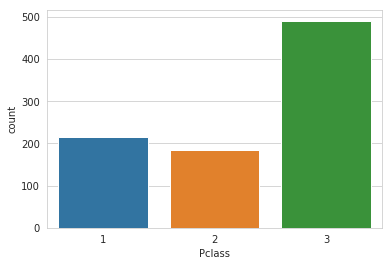

In [66]:
sns.set_style('whitegrid')
sns.countplot(x='Pclass', data=train)

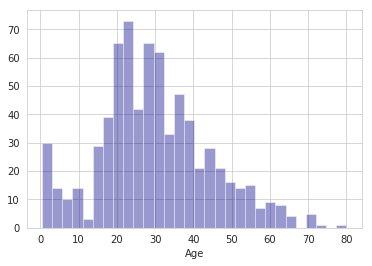

In [67]:
sns.distplot(train['Age'].dropna(), kde=False, color='darkblue', bins=30)

**Com esse outro gráfico da idade dos passageiros, podemos ver que a maioria das pessoas tinham entre 20 e 30 anos.**

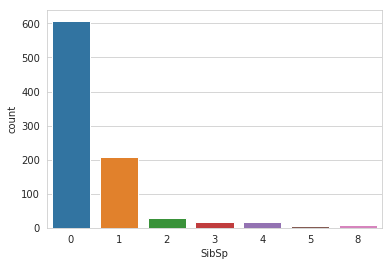

In [68]:
sns.countplot(x='SibSp',data=train)

**Por esse outro gráfico, podemos ver que a maioria das pessoas a bordo do Titanic estavam sozinhas, sem acompanhante.**

## Limpando os dados

Agora que já conhecemos melhor nossos dados, precisamos tratar os dados faltantes. Comecemos pela idade, se simplesmente excluirmos essas dados, perderemos muita informação importante. Por isso, uma forma de solucionarmos o problema é fazer uma média de todos os passageiros de acordo com sua classe e preencher os dados faltantes.

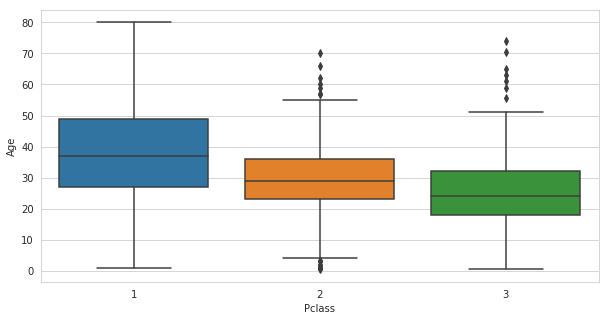

In [69]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Pclass', y='Age', data=train)

**Esse boxplot nos mostra que as pessoas mais velhas estavam na primeira classe. E pela média, vamos preencher dados faltantes da primeira classe com 37 anos, de segunda classe com 29 anos e de terceira classe com 24 anos.**

In [70]:
def add_age(cols):
    age = cols[0]
    pclass = cols[1]
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        elif pclass == 3:
            return 24
    else:
        return age
        

In [71]:
# Aplicando a função
train['Age'] = train[['Age','Pclass']].apply(add_age, axis=1)

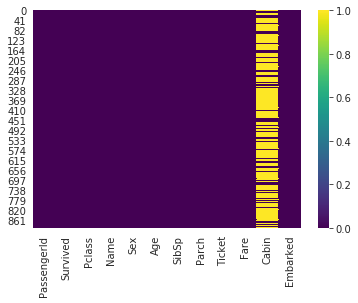

In [72]:
# Verificando se o tratamento para os dados da idade deu certo
sns.heatmap(train.isnull(), cmap='viridis')

**Prontinho, agora não temos mais idade faltante!**

Agora vamos deletar a coluna Cabin e a linha em Embarked que falta dado.

In [73]:
# Deletando a coluna Cabin
train.drop('Cabin', axis=1, inplace=True)

In [74]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [75]:
# Deletando as linhas com dados faltantes em Embarked
train.dropna(inplace=True)

Como podemos ver, não temos mais dados faltantes, todas as linhas das 8 colunas possuem o mesmo tanto de valor.

## Convertendo dados categóricos

Precisamos converter características categóricas em variáveis numérica

In [76]:
# Convertendo dados de Sexo e Local de embarcação
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [77]:
# Excluindo do dataset as colunas que não vamos utilizar
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


In [79]:
# Adicionando as novas colunas de sexo e local de embarcação
train = pd.concat([train,sex,embark],axis=1)

Vejamos agora como ficaram os dados que utilizaremos para a construção no modelo.

In [80]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


## Construindo o modelo de Regressão Logística

### Dividindo os dados em treino e teste

In [81]:
# Importando biblioteca que splita os dados
from sklearn.model_selection import train_test_split 

In [82]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

### Treinando e Predizendo

In [83]:
# Importando o módulo de Regressão Logística
from sklearn.linear_model import LogisticRegression

In [84]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
# Coeficientes
logreg.coef_

array([[ 4.07954723e-04, -7.86365697e-01, -2.63396478e-02,
        -2.12111572e-01, -9.70461813e-02,  4.63351174e-03,
        -2.34157551e+00, -1.74591240e-02, -1.93374579e-01]])

In [86]:
predictions = logreg.predict(X_test)

### Avaliando o modelo

In [87]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.86       163
          1       0.85      0.65      0.74       104

avg / total       0.82      0.82      0.81       267



In [89]:
print('A acurácia do nosso modelo foi de: {:.2f}'.format(logreg.score(X_test, y_test)))

A acurácia do nosso modelo foi de: 0.82


**Matriz de confusão:**

In [90]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(['TP  FP'])
print(confusion_matrix)
print(['FN  TN'])

['TP  FP']
[[151  12]
 [ 36  68]]
['FN  TN']
